In [1]:
from tensorflow.keras.utils import normalize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import MeanIoU
import os
from glob import glob
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

### Architektura modelu

In [15]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=544, IMG_WIDTH=544, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    p5 = MaxPooling2D(pool_size=(2, 2))(c5)
     
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
    c6 = Dropout(0.3)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    #Expansive path
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c5])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.3)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c4])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c3])
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
    u10 = concatenate([u10, c2])
    c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
    c10 = Dropout(0.1)(c10)
    c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
     
    u11 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
    u11 = concatenate([u11, c1], axis=3)
    c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
    c11 = Dropout(0.1)(c11)
    c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c11)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

Model jsem oproti prvnímu pokusu (20221030) "prohloubil", respketive kontrakční a expanzivní části jsou hlubší

In [3]:
SIZE_X = 544
SIZE_Y = 544
n_classes = 4

### Načtení a předzpracování obrázků

In [4]:
input_dir = "./Ateroskleroza_Data_Original_26_9_19/images/"
mask_dir = "./Ateroskleroza_Data_Original_26_9_19/labels/"

train_images = []
for directory_path in glob(input_dir):
    for img_path in glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0)
        train_images.append(img)
        
train_images = np.array(train_images)

train_masks = []
for directory_path in glob(mask_dir):
    for mask_path in glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)
        train_masks.append(mask)

train_masks = np.array(train_masks)

In [5]:
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1, 1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_reshaped_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_reshaped_encoded_original_shape)

C:\Users\107320\.conda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3], dtype=int64)

In [6]:
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks, axis=3)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state=42)

train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

print("Class values in the dataset are ...", np.unique(y_train))

Class values in the dataset are ... [0 1 2 3]


In [8]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_masks_reshaped_encoded),
                                        y = train_masks_reshaped_encoded                                                    
                                    )

print("Class weights are ...:", class_weights)

Class weights are ...: [ 0.3444192   2.87042313 14.82685638  1.46899924]


In [16]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

In [17]:
model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 544, 544, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_46 (Conv2D)             (None, 544, 544, 16  160         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_22 (Dropout)           (None, 544, 544, 16  0           ['conv2d_46[0][0]']              
                                )                                                           

                                                                                                  
 conv2d_60 (Conv2D)             (None, 68, 68, 128)  295040      ['concatenate_11[0][0]']         
                                                                                                  
 dropout_29 (Dropout)           (None, 68, 68, 128)  0           ['conv2d_60[0][0]']              
                                                                                                  
 conv2d_61 (Conv2D)             (None, 68, 68, 128)  147584      ['dropout_29[0][0]']             
                                                                                                  
 conv2d_transpose_12 (Conv2DTra  (None, 136, 136, 64  32832      ['conv2d_61[0][0]']              
 nspose)                        )                                                                 
                                                                                                  
 concatena

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
checkpointer = ModelCheckpoint('atherosclerosis_segmentation.h5', verbose=1, save_best_only=True)
callbacks = [
    EarlyStopping(patience=2, monitor='val_loss'),
    TensorBoard(log_dir='logs')
]

In [19]:
history = model.fit(X_train, y_train_cat,
                   batch_size = 16,
                   verbose=1,
                   epochs=50,
                   callbacks=callbacks,
                   validation_data=(X_test, y_test_cat),
                   shuffle=False)

Epoch 1/50
49/49 [==============================] - 1703s 34s/step - loss: 0.8668 - accuracy: 0.7888 - val_loss: 0.3504 - val_accuracy: 0.8646
Epoch 2/50
49/49 [==============================] - 1659s 34s/step - loss: 0.3392 - accuracy: 0.8663 - val_loss: 0.2963 - val_accuracy: 0.8689
Epoch 3/50
49/49 [==============================] - 1666s 34s/step - loss: 0.2426 - accuracy: 0.8963 - val_loss: 0.1742 - val_accuracy: 0.9371
Epoch 4/50
49/49 [==============================] - 1652s 34s/step - loss: 0.1442 - accuracy: 0.9503 - val_loss: 0.1113 - val_accuracy: 0.9604
Epoch 5/50
49/49 [==============================] - 1681s 34s/step - loss: 0.1136 - accuracy: 0.9597 - val_loss: 0.0967 - val_accuracy: 0.9653
Epoch 6/50
49/49 [==============================] - 1654s 34s/step - loss: 0.0970 - accuracy: 0.9647 - val_loss: 0.0925 - val_accuracy: 0.9661
Epoch 7/50
49/49 [==============================] - 1676s 34s/step - loss: 0.0887 - accuracy: 0.9671 - val_loss: 0.0875 - val_accuracy: 0.9677

In [20]:
model.save('20221031_atherosceloris_segmentation.h5')

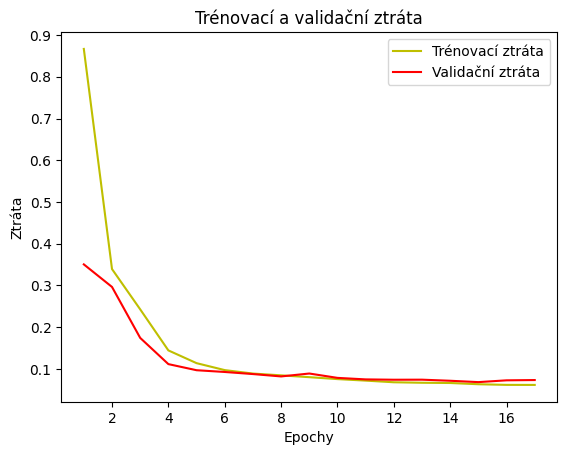

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(1, len(loss)+1)

plt.plot(epochs, loss, 'y', label='Trénovací ztráta')
plt.plot(epochs, val_loss, 'r', label='Validační ztráta ')
plt.title('Trénovací a validační ztráta')
plt.xlabel('Epochy')
plt.ylabel('Ztráta')
plt.legend()
plt.savefig('./training_loss.png')

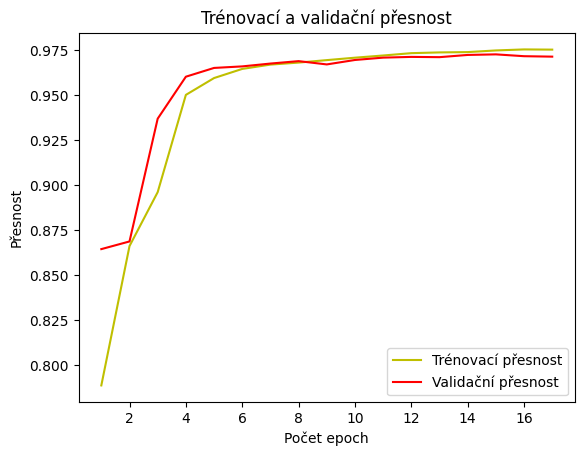

In [25]:
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs=range(1, len(loss)+1)

plt.plot(epochs, loss, 'y', label='Trénovací přesnost')
plt.plot(epochs, val_loss, 'r', label='Validační přesnost')
plt.title('Trénovací a validační přesnost')
plt.xlabel('Počet epoch')
plt.ylabel('Přesnost')


plt.legend()
plt.savefig('./training_accuracy.png')

1/1 [==============================] - 0s 447ms/step


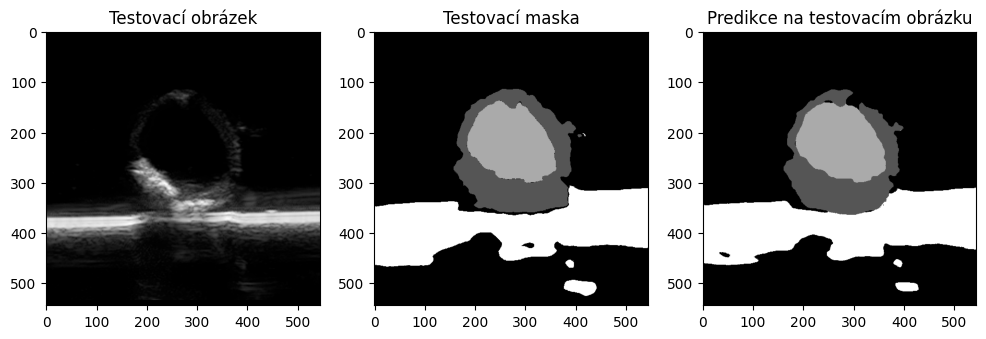

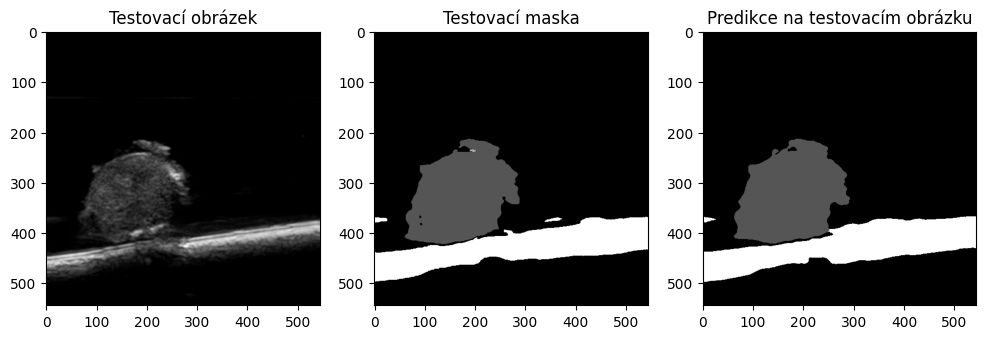

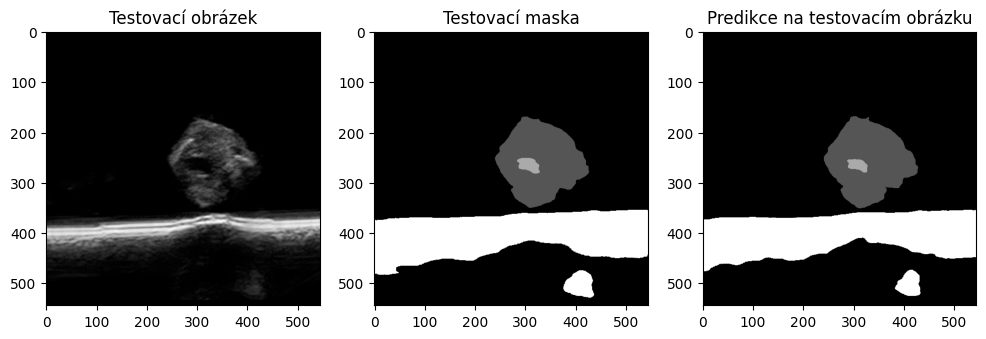

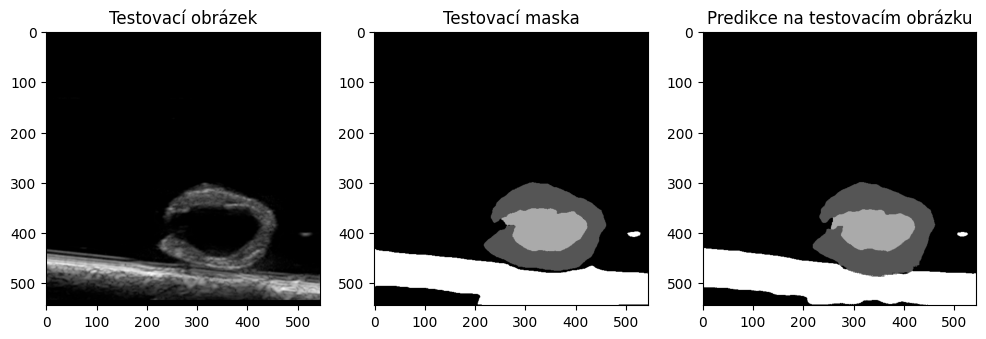

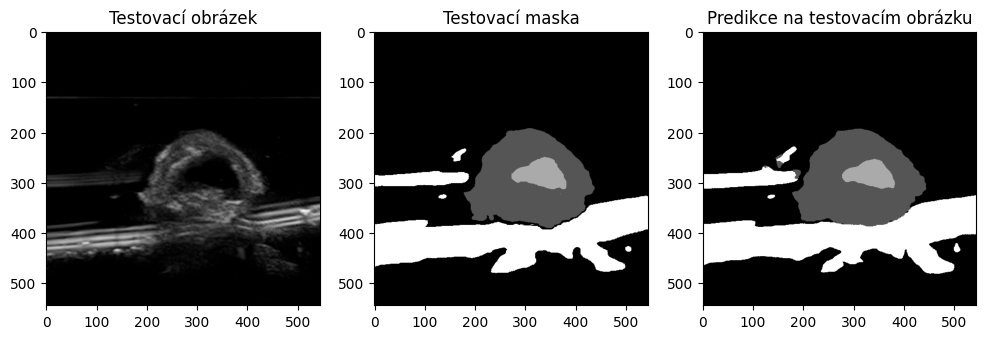

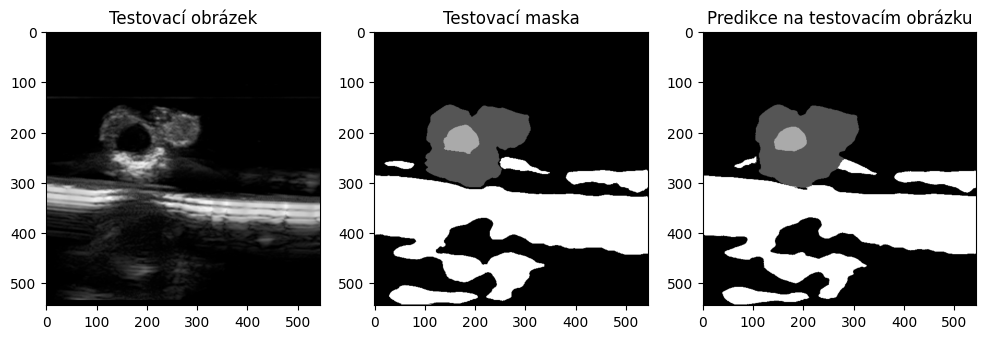

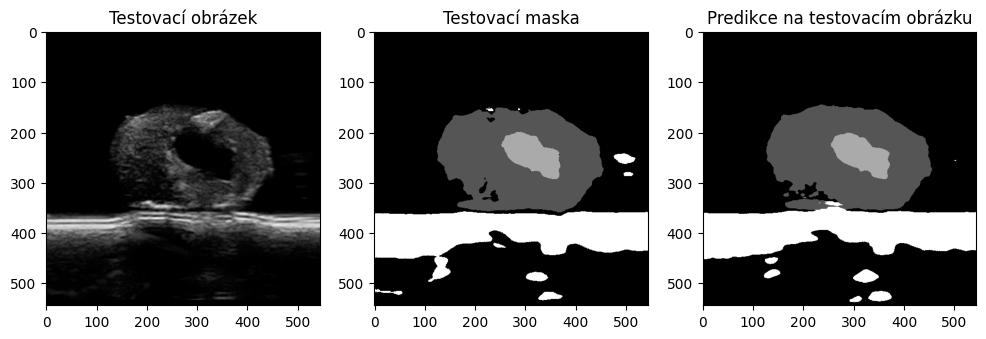

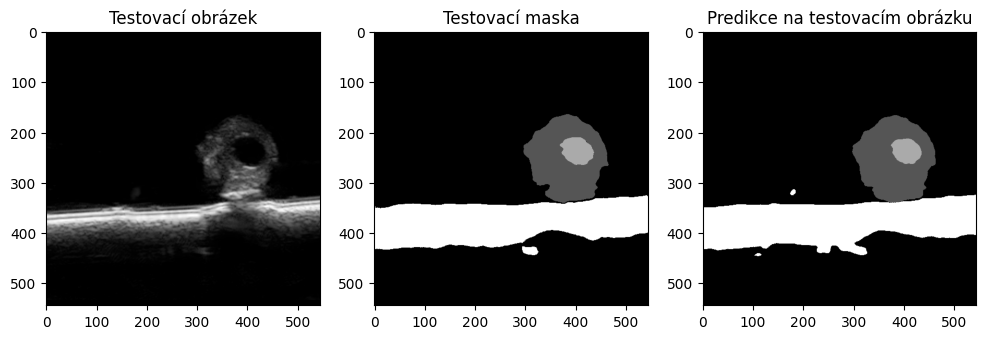

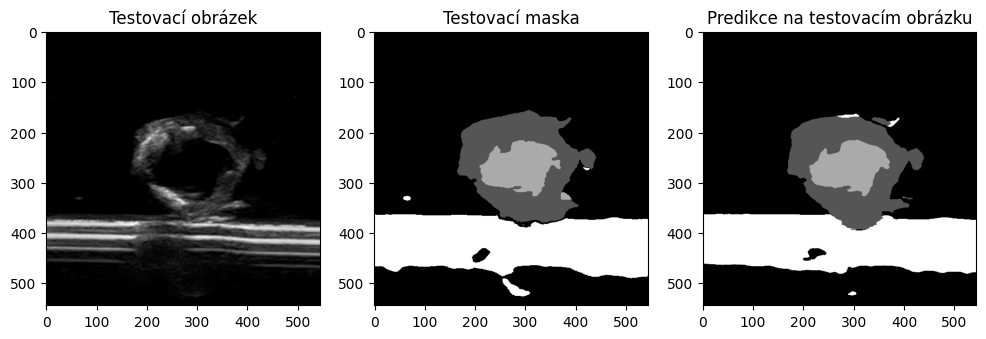

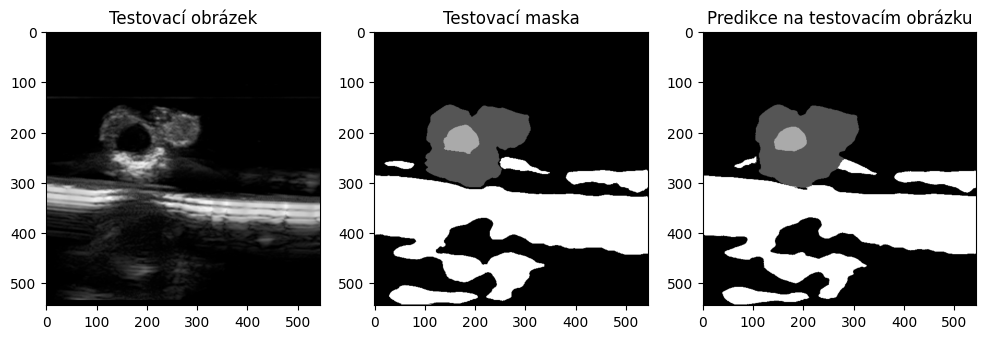

In [29]:
import random
for i in range(0, 10):
    test_img_number = random.randint(0, len(X_test))
    test_img = X_test[test_img_number]
    ground_truth=y_test[test_img_number]
    test_img_norm=test_img[:,:,0][:,:,None]
    test_img_input=np.expand_dims(test_img_norm, 0)
    prediction=(model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]

    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testovací obrázek')
    plt.imshow(test_img[:,:,0], cmap='gray')
    plt.subplot(232)
    plt.title('Testovací maska')
    plt.imshow(ground_truth[:,:,0], cmap='gray')
    plt.subplot(233)
    plt.title('Predikce na testovacím obrázku')
    plt.imshow(predicted_img, cmap='gray')
    name = './20221031_test_prediction_' + str(i) + '.png'
    #plt.show()
    plt.savefig(name)

In [28]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

3/3 [==============================] - 38s 12s/step
Mean IoU = 0.8969098


IoU => Intersection over Union

IoU = true positive / (true positive + false positive + false negative)